<a href="https://colab.research.google.com/github/HANSOYE/Aiffel-exploration-report/blob/master/going_deeper_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4-7. 프로젝트: CutMix 또는 Mixup 비교실험 하기
지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지 마세요!

우선 주요 라이브러리 버전을 확인해 볼까요?

In [ ]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


1. Augmentation을 적용한 데이터셋 만들기

-------------

이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

>Q1. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?\
\
A. 예시답안\
CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete7VQG0F/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete7VQG0F/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('=3')

=3


In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

=3


In [ ]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [ ]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

94781440/94765736 [==============================] - 1s 0us/step
=3


In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수


resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 109s 120ms/step - loss: 2.1970 - accuracy: 0.4532 - val_loss: 3.4622 - val_accuracy: 0.1966
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 0.7087 - accuracy: 0.8086 - val_loss: 1.0851 - val_accuracy: 0.6736
Epoch 3/20
750/750 [==============================] - 89s 118ms/step - loss: 0.2615 - accuracy: 0.9449 - val_loss: 0.9685 - val_accuracy: 0.7207
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0712 - accuracy: 0.9919 - val_loss: 0.9053 - val_accuracy: 0.7424
Epoch 5/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0226 - accuracy: 0.9994 - val_loss: 0.9207 - val_accuracy: 0.7421
Epoch 6/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0162 - accuracy: 0.9996 - val_loss: 0.9378 - val_accuracy: 0.7436
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0103 - accuracy: 0.9998 - val_loss: 0.9442 - val_accuracy: 0.

In [ ]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 98s 119ms/step - loss: 2.2791 - accuracy: 0.4262 - val_loss: 2.9337 - val_accuracy: 0.2720
Epoch 2/20
750/750 [==============================] - 89s 118ms/step - loss: 0.9390 - accuracy: 0.7294 - val_loss: 1.1516 - val_accuracy: 0.6606
Epoch 3/20
750/750 [==============================] - 89s 118ms/step - loss: 0.4931 - accuracy: 0.8646 - val_loss: 1.2099 - val_accuracy: 0.6476
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 0.2451 - accuracy: 0.9424 - val_loss: 1.0467 - val_accuracy: 0.7024
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1369 - accuracy: 0.9736 - val_loss: 1.1115 - val_accuracy: 0.6966
Epoch 6/20
750/750 [==============================] - 89s 118ms/step - loss: 0.1054 - accuracy: 0.9812 - val_loss: 0.9959 - val_accuracy: 0.7232
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0549 - accuracy: 0.9920 - val_loss: 0.9752 - val_accuracy: 0.7

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup = False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [ ]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True)


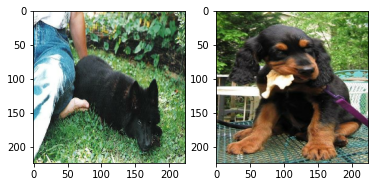

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 두 개를 가져온다.
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break
        
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1, 2, 2)
plt.imshow(image_b)

plt.show()

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(61, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(149, shape=(), dtype=int32)


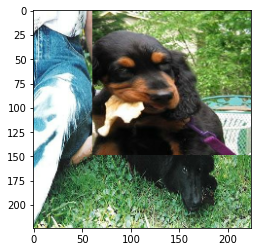

In [ ]:
# min two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min : y_max,  : x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min : y_max, x_min : x_max, :] #image_b의 안쪽 영역
    middle_right = image_a[y_min : y_max, x_max : image_size_x, :] #image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left, middle_center, middle_right], axis = 1)
    top = image_a[0 : y_min, :, :]
    bottom = image_a[y_max : image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis = 0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [ ]:
#mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes = 120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a,num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.4840362, 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.5159638, 0.       , 0.       , 0.       , 0.       ,
   

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [ ]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [ ]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
#ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test_onehot = apply_normalize_on_dataset(ds_test, is_test = True)
#ds_test_one = apply_normalize_on_dataset(ds_test, onehot=True, is_test = True)

In [ ]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = aug_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_onehot,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 108s 127ms/step - loss: 1.4785 - accuracy: 0.8397 - val_loss: 1.5407 - val_accuracy: 0.6540
Epoch 2/20
750/750 [==============================] - 94s 125ms/step - loss: 1.4576 - accuracy: 0.8333 - val_loss: 1.2909 - val_accuracy: 0.7071
Epoch 3/20
750/750 [==============================] - 94s 125ms/step - loss: 1.4464 - accuracy: 0.8382 - val_loss: 1.4562 - val_accuracy: 0.6775
Epoch 4/20
750/750 [==============================] - 95s 127ms/step - loss: 1.4305 - accuracy: 0.8414 - val_loss: 1.5545 - val_accuracy: 0.6364
Epoch 5/20
750/750 [==============================] - 94s 125ms/step - loss: 1.4124 - accuracy: 0.8439 - val_loss: 1.5949 - val_accuracy: 0.6557
Epoch 6/20
750/750 [==============================] - 97s 130ms/step - loss: 1.4094 - accuracy: 0.8400 - val_loss: 1.5014 - val_accuracy: 0.6747
Epoch 7/20
750/750 [==============================] - 96s 128ms/step - loss: 1.3893 - accuracy: 0.8399 - val_loss: 1.4652 - val_a

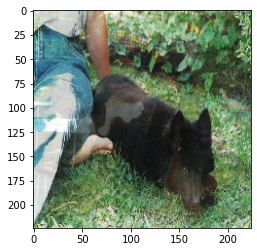

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.2270484 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.7729516 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [ ]:
#function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image = (1 - ratio) * image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio * label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [ ]:
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

In [ ]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [ ]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = aug_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_onehot,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 103s 125ms/step - loss: 1.7820 - accuracy: 0.8561 - val_loss: 1.5990 - val_accuracy: 0.6526
Epoch 2/20
750/750 [==============================] - 93s 124ms/step - loss: 1.7255 - accuracy: 0.8606 - val_loss: 1.9015 - val_accuracy: 0.5915
Epoch 3/20
750/750 [==============================] - 93s 125ms/step - loss: 1.7188 - accuracy: 0.8627 - val_loss: 1.8540 - val_accuracy: 0.6042
Epoch 4/20
750/750 [==============================] - 95s 127ms/step - loss: 1.6915 - accuracy: 0.8669 - val_loss: 1.5647 - val_accuracy: 0.6811
Epoch 5/20
750/750 [==============================] - 94s 125ms/step - loss: 1.6638 - accuracy: 0.8772 - val_loss: 1.6352 - val_accuracy: 0.6438
Epoch 6/20
750/750 [==============================] - 94s 125ms/step - loss: 1.6705 - accuracy: 0.8678 - val_loss: 1.6168 - val_accuracy: 0.6614
Epoch 7/20
750/750 [==============================] - 96s 128ms/step - loss: 1.6485 - accuracy: 0.8736 - val_loss: 1.4708 - val_accuracy: 0.

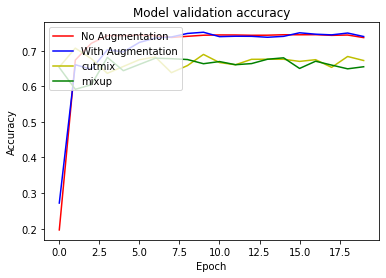

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')
plt.show()

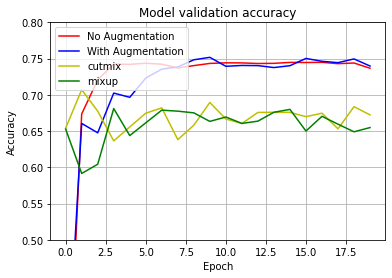

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()